In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
import pdb
import seaborn as sns
%matplotlib inline

In [2]:
# Load Bryce's data
raw_df = pd.read_csv('data/in_vivo_data.csv.gz', compression='gzip')

# Rename columns and samples for added convenience
raw_df.rename(columns={'DNA count':'DNA'}, inplace=True)
raw_df['treatment'] = np.where(raw_df['treatment']=='All_end', 'all', raw_df['treatment'])
raw_df['treatment'] = np.where(raw_df['treatment']=='background', 'P', raw_df['treatment'])

#Rename treatment and replicates
raw_df['treatment'] = raw_df['treatment'].map({'P':'none', 
                                       'PPP+P':'Rpp', 
                                       'OH+P':'PNK', 
                                       'all':'both'})
raw_df['sample'] = raw_df['sample'].map({'KS112':'rep1', 
                                 'KS113':'rep2', 
                                 'KS114':'rep3'})

# Drop DNA column
raw_df.drop(columns=['DNA'], inplace=True)

# Preview dataframe
raw_df.head()

,N10,treatment,sample,p4,p5,p6,p7,p8,p9,p10
0,AAAAAAAAAA,both,rep1,0,0,0,0,0,0,0
1,AAAAAAAAAC,both,rep1,0,0,0,0,0,0,0
2,AAAAAAAAAG,both,rep1,0,0,0,0,0,0,0
3,AAAAAAAAAT,both,rep1,0,0,0,0,0,0,0
4,AAAAAAAACA,both,rep1,0,0,0,0,0,0,0


In [3]:
# Sum across N10 sequences
sum_df = raw_df.groupby(['treatment','sample']).sum()
sum_df

p4     p5      p6       p7       p8      p9    p10
treatment sample                                                      
PNK       rep1    2159  18472  171298   424330   297070   42419   9740
          rep2    2203  19020  178467   408130   281619   36924   8993
          rep3    1981  17266  162142   363861   250827   34292   8845
Rpp       rep1    2284  16532  116990  1122393  1005002  175858  15351
          rep2    2479  17349  121263  1059097   934347  161024  14103
          rep3    2248  15708  110428   986685   883533  155240  14984
both      rep1    3190  28138  256476  1301158  1055196  180330  18186
          rep2    3547  29141  265148  1217222   969366  163306  16739
          rep3    3118  26252  237161  1078663   867636  143873  15589
none      rep1    1717  11909   71287   381157   330009   48133  10077
          rep2    1839  12044   70791   345523   296254   40609   8837
          rep3    1578  11152   66784   326953   283616   39450   8507

In [4]:
# Name shit
L = 7
poss = [f'p{pos}' for pos in range(4,11)]
reps = ['rep1', 'rep2', 'rep3']
samples = ['none','Rpp','PNK','both']
ends = ['PPP_v1', 'PPP_v2', 'OH_v1', 'OH_v2']

First we use two different ways to naively compute the number of PPP-end and OH-end mRNAs. These four profiles are computed separately for each of the three replicates.

$$\vec{c}_{PPP,1} = \vec{c}_{both} - \vec{c}_{PNK},$$
$$\vec{c}_{PPP,2} = \vec{c}_{Rpp} - \vec{c}_{none},$$
$$\vec{c}_{OH,1} = \vec{c}_{both} - \vec{c}_{Rpp},$$
$$\vec{c}_{OH,2} = \vec{c}_{PNK} - \vec{c}_{none}.$$


In [5]:
# Compute naive counts profiles
pairs = [(end, rep) for end in ends for rep in reps]
index = pd.MultiIndex.from_tuples(pairs, names=["end", "sample"])
naive_ct_df = pd.DataFrame(index=index, columns=poss)

for rep in reps:
    
    # Get df corresponding to specific replicate
    tmp_df = sum_df.loc[pd.IndexSlice[:, rep], :]
    tmp_df.index = samples
    
    # Extract count vectors
    naive_ct_df.loc[('PPP_v1',rep),:] = sum_df.loc[('both', rep),:] - sum_df.loc[('PNK', rep),:]
    naive_ct_df.loc[('PPP_v2',rep),:] = sum_df.loc[('Rpp', rep),:] - sum_df.loc[('none', rep),:]
    naive_ct_df.loc[('OH_v1',rep),:] = sum_df.loc[('both', rep),:] - sum_df.loc[('Rpp', rep),:]
    naive_ct_df.loc[('OH_v2',rep),:] = sum_df.loc[('PNK', rep),:] - sum_df.loc[('none', rep),:]
    
naive_ct_df.to_csv('csv_results/pct_profiles_naive.csv')
naive_ct_df

p4     p5      p6      p7      p8      p9   p10
end    sample                                                   
PPP_v1 rep1    1031   9666   85178  876828  758126  137911  8446
       rep2    1344  10121   86681  809092  687747  126382  7746
       rep3    1137   8986   75019  714802  616809  109581  6744
PPP_v2 rep1     567   4623   45703  741236  674993  127725  5274
       rep2     640   5305   50472  713574  638093  120415  5266
       rep3     670   4556   43644  659732  599917  115790  6477
OH_v1  rep1     906  11606  139486  178765   50194    4472  2835
       rep2    1068  11792  143885  158125   35019    2282  2636
       rep3     870  10544  126733   91978  -15897  -11367   605
OH_v2  rep1     442   6563  100011   43173  -32939   -5714  -337
       rep2     364   6976  107676   62607  -14635   -3685   156
       rep3     403   6114   95358   36908  -32789   -5158   338

To visualize these, we normalize each counts vector by the number of reads to get a probability distribution across positions $i = 4, 5, ..., 10$. 
    
$$\vec{p}_{xxx}(i) = \frac{\vec{c}_{xxx}(i)}{\sum_j \vec{p}_{xxx}(j)} $$

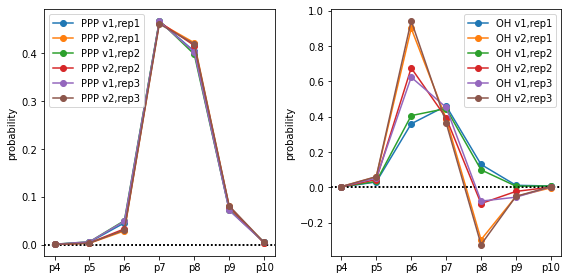

In [6]:
# Plot naive count profiles
fig, axs = plt.subplots(1,2,figsize=[8,4])
xs = list(range(4,11))

ax = axs[0]
for rep in reps:
    ax.axhline(0, linestyle=':', color='k')
    for end in ['PPP_v1', 'PPP_v2']:
        cts = naive_ct_df.loc[(end, rep),:]
        probs = cts/np.sum(cts)
        ax.plot(xs, probs, '-o', label=f'{end.replace("_"," ")},{rep}')
    ax.set_ylabel('probability')
    ax.set_xticks(xs)
    ax.set_xticklabels(poss)
    ax.legend()
    
ax = axs[1]
for rep in reps:
    ax.axhline(0, linestyle=':', color='k')
    for end in ['OH_v1', 'OH_v2']:
        cts = naive_ct_df.loc[(end, rep),:]
        probs = cts/np.sum(cts)
        ax.plot(xs, probs, '-o', label=f'{end.replace("_"," ")},{rep}')
    ax.set_ylabel('probability')
    ax.set_xticks(xs)
    ax.set_xticklabels(poss)
    ax.legend()
    
fig.tight_layout()
#fig.savefig(f'results/naive_profiles.pdf')

The six OH profiles are messed up. They show substantial variation across replications. Moreover, four of them have probabilities well below zero (at p8 and p9). 

We therefore consider the possibility that each enzymatic treatment has an efficiency below 100%. Let the efficiencies of four treatments be $\epsilon_{both}$, $\epsilon_{PNK}$, $\epsilon_{Rpp}$, and $\epsilon_{none}$. Then the number of true underlying counts in the four samples become:

$$\vec{c}_{PPP,1} = \frac{\vec{c}_{both}}{\epsilon_{both}} - \frac{\vec{c}_{PNK}}{\epsilon_{PNK}},$$
$$\vec{c}_{PPP,2} = \frac{\vec{c}_{Rpp}}{\epsilon_{Rpp}} - \frac{\vec{c}_{none}}{\epsilon_{none}},$$
$$\vec{c}_{OH,1} = \frac{\vec{c}_{both}}{\epsilon_{both}} - \frac{\vec{c}_{Rpp}}{\epsilon_{PNK}},$$
$$\vec{c}_{OH,2} = \frac{\vec{c}_{PNK}}{\epsilon_{Rpp}} - \frac{\vec{c}_{none}}{\epsilon_{none}}.$$

We can solve for the unknown efficiencies by setting $\vec{c}_{PPP,1} = \vec{c}_{PPP,2}$, or equivalently $\vec{c}_{OH,1} = \vec{c}_{OH,2}$, both of which give

 $$ \frac{\vec{c}_{both}}{\epsilon_{both}} - \frac{\vec{c}_{PNK}}{\epsilon_{PNK}} - \frac{\vec{c}_{Rpp}}{\epsilon_{Rpp}} + \frac{\vec{c}_{none}}{\epsilon_{none}} = 0$$

This provides a system of 7 equations with 4 unknowns. We can't determine absolute overall efficiencies, but setting $\epsilon_{none}=1$ does allow us to solve for the other three relative efficiencies. We do this by minimizing the objective function 

$$\sum_i\frac{\vec{r}(i)^2}{\vec{v}(i)}$$

where 

$$\vec{r} = \frac{\vec{c}_{both}}{\epsilon_{both}} - \frac{\vec{c}_{PNK}}{\epsilon_{PNK}} - \frac{\vec{c}_{Rpp}}{\epsilon_{Rpp}} + \frac{\vec{c}_{none}}{\epsilon_{none}}$$ 

is the vector of residuals and

$$ \vec{v} = \frac{\vec{c}_{both}}{\epsilon_{both}^2} - \frac{\vec{c}_{PNK}}{\epsilon_{PNK}^2} - \frac{\vec{c}_{Rpp}}{\epsilon_{Rpp}^2} + \frac{\vec{c}_{none}}{\epsilon_{none}^2}$$ 

is the correpsonding vector of Poisson variances.

In [7]:
# Define objective function
def objective(x, rep, min_std=1):
    c_both = sum_df.loc[('both', rep),:]
    c_PNK = sum_df.loc[('PNK', rep),:]
    c_Rpp = sum_df.loc[('Rpp', rep),:]
    c_none = sum_df.loc[('none', rep),:]
    eps_Rpp, eps_PNK, eps_both = x

    # Compute residuals
    residuals = c_both/eps_both - c_PNK/eps_PNK - c_Rpp/eps_Rpp + c_none
    
    # Compute variances assuming possion flucuations in c_xxx
    variances = c_both/eps_both**2 + c_PNK/eps_PNK**2 + c_Rpp/eps_Rpp**2 + c_none
    
    # Compute objective function to minimize
    obj = np.sum((residuals**2)/variances)
    
    return obj

# Compute efficiendies for each replicate

# Iterate over repliates
eps_df = pd.DataFrame(index=reps, columns=samples)
eps_df.index.name = 'rep'
profile_df = pd.DataFrame(columns=['rep', 'profile']+poss)
for rep in reps:
    
    # Perform optimization, using upper and lower bounds for safety sake
    bounds = [(.01, 100)]*3
    result = minimize(objective, x0=[1, 1, 1], args=(rep), bounds=bounds)
    eps_Rpp, eps_PNK, eps_both = result.x
    eps_df.loc[rep,:] = [1., eps_Rpp, eps_PNK, eps_both]
    
eps_df = eps_df.reset_index().melt(id_vars='rep', value_vars=samples, )
eps_df.columns = ['replicate','sample','efficiency']
eps_df = eps_df[['sample','replicate','efficiency']]
eps_df.to_csv(f'csv_results/efficiencies.csv', index=False)
eps_df

,sample,replicate,efficiency
0,none,rep1,1.0
1,none,rep2,1.0
2,none,rep3,1.0
3,Rpp,rep1,0.910393
4,Rpp,rep2,0.922886
5,Rpp,rep3,0.98748
6,PNK,rep1,0.755147
7,PNK,rep2,0.751011
8,PNK,rep3,0.753237
9,both,rep1,0.911045


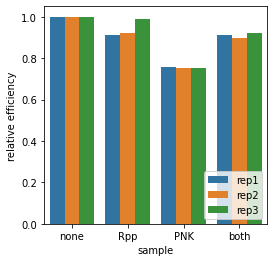

In [8]:
# Plot efficiencies
fig, ax = plt.subplots(1,1,figsize=[4,4])
eps_df = pd.read_csv(f'csv_results/efficiencies.csv').set_index(['sample','replicate'])
eps_df = eps_df.reset_index()
sns.barplot(data=eps_df, y='efficiency', x='sample', hue='replicate', ax=ax)
ax.set_ylabel('relative efficiency')
ax.legend(loc='lower right')
#fig.savefig(f'results/efficiencies.pdf')

In [9]:
# Load efficiencies
eps_series = pd.read_csv(f'csv_results/efficiencies.csv', index_col=[0,1])['efficiency']
eps_series

# Compute adjusted counts profiles
pairs = [(end, rep) for end in ends+['PPP','OH'] for rep in reps]
index = pd.MultiIndex.from_tuples(pairs, names=["end", "sample"])
adjusted_ct_df = pd.DataFrame(index=index, columns=poss)

for rep in reps:
    
    # Get df corresponding to specific replicate
    tmp_df = sum_df.loc[pd.IndexSlice[:, rep], :]
    tmp_df.index = samples
    
    # Extract count vectors
    adjusted_ct_df.loc[('PPP_v1',rep),:] = sum_df.loc[('both', rep),:]/eps_series[('both', rep)] \
                                         - sum_df.loc[('PNK', rep),:]/eps_series[('PNK', rep)] 
    
    adjusted_ct_df.loc[('PPP_v2',rep),:] = sum_df.loc[('Rpp', rep),:]/eps_series[('Rpp', rep)] \
                                         - sum_df.loc[('none', rep),:]/eps_series[('none', rep)]
    
    adjusted_ct_df.loc[('PPP',rep),:] = .5*(adjusted_ct_df.loc[('PPP_v1',rep),:] 
                                            + adjusted_ct_df.loc[('PPP_v2',rep),:])
    
    adjusted_ct_df.loc[('OH_v1',rep),:] = sum_df.loc[('both', rep),:]/eps_series[('both', rep)] \
                                        - sum_df.loc[('Rpp', rep),:]/eps_series[('Rpp', rep)] 
    
    adjusted_ct_df.loc[('OH_v2',rep),:] = sum_df.loc[('PNK', rep),:]/eps_series[('PNK', rep)] \
                                        - sum_df.loc[('none', rep),:]/eps_series[('none', rep)] 
    
    adjusted_ct_df.loc[('OH',rep),:] = .5*(adjusted_ct_df.loc[('OH_v1',rep),:] 
                                           + adjusted_ct_df.loc[('OH_v2',rep),:])
    
adjusted_ct_df

p4            p5             p6             p7  \
end    sample                                                            
PPP_v1 rep1     642.428171    6423.95422   54677.919649  866286.870523   
       rep2    1023.292276   7180.866816   58136.401255  814367.831253   
       rep3     751.040662   5544.121502   41906.753451    686592.0686   
PPP_v2 rep1     791.807983   6250.200341   57218.011365  851710.127282   
       rep2     847.138526   6754.635453   60604.407861   802069.27695   
       rep3     698.502057    4755.15939   45044.100145  672242.031977   
OH_v1  rep1     992.665435  12726.210017  153013.451464  195336.681485   
       rep2    1270.532236  13708.086478  164376.607741  210216.208785   
       rep3    1104.521748  12559.369447  145338.989806  170460.285497   
OH_v2  rep1    1142.045247  12552.456138  155553.543179  180759.938244   
       rep2    1094.378487  13281.855115  166844.614347  197917.654483   
       rep3    1051.983142  11770.407334  148476.336499  156110.248874   
PPP    rep1     717.118077    6337.07728   55947.965507  858998.498903   
       rep2     935.215401   6967.751135   59370.404558  808218.554102   
       rep3      724.77136   5149.640446   43475.426798  679417.050288   
OH     rep1    1067.355341  12639.333078  154283.497322  188048.309864   
       rep2    1182.455362  13494.970797  165610.611044  204066.931634   
       rep3    1078.252445  12164.888391  146907.663153  163285.267185   

                          p8             p9          p10  
end    sample                                             
PPP_v1 rep1     764832.43656  141764.369594  7063.543788  
       rep2    706339.223514  133001.773077  6697.795638  
       rep3    607827.922147  110483.443922  5161.378991  
PPP_v2 rep1    773912.646565  145034.230435  6784.957684  
       rep2    716164.504813  133869.729336  6444.408485  
       rep3    611119.183151   117758.26481  6666.979902  
OH_v1  rep1     54304.292326    4770.293551  3099.733722  
       rep2     68907.153599    7688.757426  3390.909501  
       rep3     46091.619132   -1198.631133  1730.054764  
OH_v2  rep1     63384.502331    8040.154393  2821.147617  
       rep2     78732.434897    8556.713685  3137.522348  
       rep3     49382.880136    6076.189755  3235.655674  
PPP    rep1    769372.541562  143399.300014  6924.250736  
       rep2    711251.864164  133435.751207  6571.102061  
       rep3    609473.552649  114120.854366  5914.179446  
OH     rep1     58844.397329    6405.223972   2960.44067  
       rep2     73819.794248    8122.735555  3264.215924  
       rep3     47737.249634    2438.779311  2482.855219

In [10]:
Ns = adjusted_ct_df.sum(axis=1)
pct_df = 100*adjusted_ct_df/Ns.values[:,np.newaxis]
pct_df.to_csv('csv_results/pct_profiles_corrected.csv')
pct_df

p4        p5         p6         p7         p8        p9  \
end    sample                                                                  
PPP_v1 rep1    0.034883  0.348807   2.968897  47.037566  41.528803  7.697509   
       rep2    0.059261  0.415861   3.366816  47.161961   40.90577  7.702446   
       rep3    0.051502  0.380186   2.873737  47.082749  41.681533  7.576354   
PPP_v2 rep1    0.042993  0.339371   3.106801  46.245817    42.0216  7.875011   
       rep2     0.04906  0.391175    3.50973  46.449537  41.474609  7.752681   
       rep3    0.047899  0.326079   3.088842  46.098149  41.906727  8.075124   
OH_v1  rep1    0.233985  2.999743   36.06738  46.043548   12.80027  1.124424   
       rep2     0.27058  2.919358  35.006648   44.76893  14.674889  1.637445   
       rep3    0.293688  3.339492  38.645126   45.32479  12.255599 -0.318712   
OH_v2  rep1    0.269189  2.958714   36.66521  42.606559  14.940233  1.895128   
       rep2    0.233062  2.828543  35.531727  42.149134  16.767094  1.822263   
       rep3    0.279706  3.129564  39.477499  41.507235  13.130123  1.615562   
PPP    rep1    0.038938  0.344089   3.037849   46.64169  41.775202   7.78626   
       rep2     0.05416  0.403518   3.438273  46.805748   41.19019  7.727563   
       rep3    0.049701  0.353132    2.98129  46.590446   41.79413   7.82574   
OH     rep1    0.251587  2.979228  36.366299  44.325032  13.870265  1.509781   
       rep2    0.251821   2.87395   35.26919  43.459023  15.720999  1.729855   
       rep3    0.286697  3.234526  39.061322  43.415968  12.692872  0.648448   

                    p10  
end    sample            
PPP_v1 rep1    0.383536  
       rep2    0.387885  
       rep3    0.353939  
PPP_v2 rep1    0.368407  
       rep2    0.373209  
       rep3     0.45718  
OH_v1  rep1     0.73065  
       rep2    0.722149  
       rep3    0.460015  
OH_v2  rep1    0.664967  
       rep2    0.668176  
       rep3    0.860309  
PPP    rep1    0.375971  
       rep2    0.380547  
       rep3     0.40556  
OH     rep1    0.697808  
       rep2    0.695162  
       rep3    0.660167

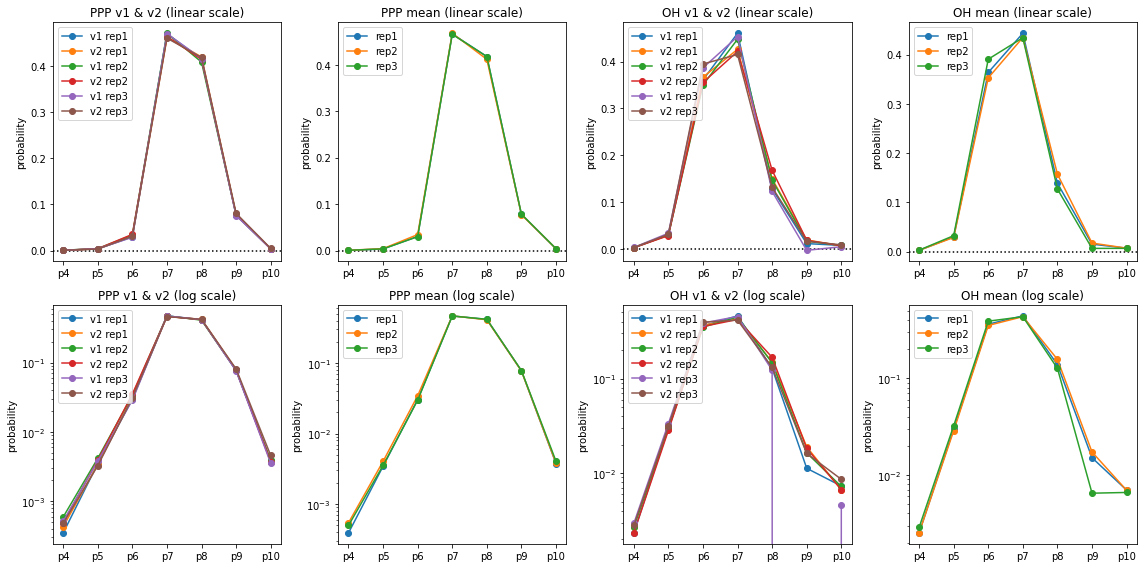

In [11]:
fig, axs = plt.subplots(2,4,figsize=[16,8])

# Load efficiencies, and set index in a a useful way
eps_df = pd.read_csv(f'csv_results/efficiencies.csv').set_index(['sample','replicate'])

for rep in reps:
    
    # Compute counts profiles   
    c_PPP_1 = adjusted_ct_df.loc[('PPP_v1',rep),:]
    c_PPP_2 = adjusted_ct_df.loc[('PPP_v2',rep),:]
    c_PPP = adjusted_ct_df.loc[('PPP',rep),:]
    c_OH_1 = adjusted_ct_df.loc[('OH_v1',rep),:]
    c_OH_2 = adjusted_ct_df.loc[('OH_v2',rep),:]
    c_OH = adjusted_ct_df.loc[('OH',rep),:]
    
    # Compute normalized profiles
    p_PPP_1 = c_PPP_1/np.sum(c_PPP_1)
    p_PPP_2 = c_PPP_2/np.sum(c_PPP_2)
    p_PPP = c_PPP/np.sum(c_PPP)
    p_OH_1 = c_OH_1/np.sum(c_OH_1)
    p_OH_2 = c_OH_2/np.sum(c_OH_2)
    p_OH = c_OH/np.sum(c_OH)
    
    for i, yscale in enumerate(['linear','log']):
        
        ax = axs[i,0]
        ax.plot(p_PPP_1, '-o', label=f'v1 {rep}')
        ax.plot(p_PPP_2, '-o', label=f'v2 {rep}')
        ax.set_title(f'PPP v1 & v2 ({yscale} scale)')
        ax.set_yscale(yscale)

        ax = axs[i,1]
        ax.plot(p_PPP, '-o', label=f'{rep}')
        ax.set_title(f'PPP mean ({yscale} scale)')
        ax.set_yscale(yscale)

        ax = axs[i,2]
        ax.plot(p_OH_1, '-o', label=f'v1 {rep}')
        ax.plot(p_OH_2, '-o', label=f'v2 {rep}')
        ax.set_title(f'OH v1 & v2 ({yscale} scale)')
        ax.set_yscale(yscale)

        ax = axs[i,3]
        ax.plot(p_OH, '-o', label=f'{rep}')
        ax.set_title(f'OH mean ({yscale} scale)')
        ax.set_yscale(yscale)
    
for ax in axs.ravel():
    ax.axhline(0, linestyle=':', color='k', zorder=-1)
    ax.set_ylabel('probability')
    ax.set_xticks(range(L))
    ax.set_xticklabels(poss)
    ax.legend(loc='upper left')
    
fig.tight_layout()
#fig.savefig(f'results/corrected_profiles.pdf')